In [1]:
from collections import defaultdict

import pandas as pd
from tableone import TableOne
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from utils.benchmark import metrics
from utils import medswitch
import utils.benchmark.plot as benchmark_plot

from utils.medswitchplot import plotPatientTrajectorySankey

# options
%matplotlib inline
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 30)

sns.set_style("white")
sns.set_context("talk")



/wynton/protected/home/ichs/bmiao/anaconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create brand name -> generic mapping
all_drugs = pd.read_csv("./data/ncdmard/raw/med_mapping.csv")

all_drugs = all_drugs.dropna(subset=["drug_class"])
all_drugs = all_drugs[all_drugs["drug_class"].str.contains("anti-TNF")]

# Create brand name -> generic mapping
med_mapping = dict(zip(all_drugs["reference_brand_name"].str.lower(), all_drugs["generic_name"].str.lower()))
generic_dict = {b.lower():g.lower()+"-"+s.lower() for b,g,s in 
                zip(all_drugs["biosimilar_brand_name"], all_drugs["generic_name"], all_drugs["biosimilar_suffix"])
               if type(b)==str}
med_mapping.update(generic_dict)



In [3]:
for i,k in med_mapping.items():
    print(f"{i}\t{k}")
    


cimzia	certolizumab
enbrel	etanercept
humira	adalimumab
remicade	infliximab
simponi	golimumab
eticovo	etanercept-ykro
erelzi	etanercept-szzs
yuflyma	adalimumab-aaty
idacio	adalimumab-aacf
yusimry	adalimumab-aqvh
hulio	adalimumab-fkjp
abrilada	adalimumab-afzb
hadlima	adalimumab-bwwd
hyrimoz	adalimumab-adaz
cyltezo	adalimumab-adbm
amjevita	adalimumab-atto
avsola	infliximab-axxq
ixifi	infliximab-qbtx
renflexis	infliximab-abda
inflectra	infliximab-dyyb


# Table 1: Demographics

In [148]:
pt_df["first_mapped_med_generic_clean"].unique()


array(['certolizumab', 'etanercept', 'adalimumab', 'infliximab',
       'golimumab', 'infliximab (biosimilar)'], dtype=object)

In [149]:
# Load annotated medication data
annot_med_df = pd.read_parquet("./data/ncdmard/annotated_medications.parquet.gzip").reset_index(drop=True)

# Load patient data
pt_df = pd.read_parquet("./data/ncdmard/annotated_pt_demographics.parquet.gzip").reset_index(drop=True)

pt_df = pt_df[pt_df["med_switching_label"]!="No TNFi with notes"]
pt_df = pt_df[pt_df["med_switching_label"]!="No switch (No final follow-up)"]
pt_df["med_switching_label_clean"] = ["TNFi switch" if "TNFi switch" in s
                                     else s for s in pt_df["med_switching_label"]]

pt_df["age_first_tnfi"] = [(c-b).days/365 for c,b in 
                                   zip(pt_df["first_ncdmard_startdatekeyvalue"],
                                      pt_df["birthdate"])]
pt_df["follow_up_time_years"] = [(c-b).days/365 for c,b in 
                                   zip(pt_df["last_encounter_datekeyvalue"],
                                      pt_df["first_ncdmard_startdatekeyvalue"])]
pt_df["final_mapped_med_generic_clean"] = [s if s is None else s[0] for s in pt_df["final_mapped_med_generic_clean"]]
pt_df["first_mapped_med_generic_clean"] = [s[0] if s is not None else s for s in pt_df["final_unique_med_trajectory"]]

pt_df["first_mapped_med_generic_clean"] = [None if type(s)!=str
           else s.split("-")[0]+" (biosimilar)" if "-" in s
           else s for s in pt_df["first_mapped_med_generic_clean"]]


# Add disease information
diagnosis_df = pd.read_csv("./data/ncdmard/medications_with_diagnosis.csv")

## Merge multiple diagnosis -> Multiple
diag_dict = diagnosis_df.groupby(["patientdurablekey"])["diagnosisname_clean"].apply(set)
diag_dict = dict(diag_dict)
diag_dict_clean = {}
for k,v in diag_dict.items():
    if "Unspecified" in v and len(v)==1:
        v = "Unspecified"
    elif "Other" in v and len(v)==1:
        v = "Other"
    elif "Other" in v:
        v = [curr_v for curr_v in v if curr_v!="Other"]
    elif "Unspecified" in v:
        v = [curr_v for curr_v in v if curr_v!="Unspecified"]
    else:
        v = list(v)
        
    if type(v)==list:
        if len(v) == 1:
            v = v[0]
        elif len(v) > 1:
            v = "Multiple"
            
    # Grouping counts < 10
            
    diag_dict_clean[k] = v



In [180]:

## Map to values
diag_pts = list(diagnosis_df["patientdurablekey"].unique())
pt_df["diagnosis"] = [diag_dict_clean[pt] if pt in diag_dict_clean
                      else None if pt not in diag_pts
                      else "Unspecified" for pt in pt_df["patientdurablekey"] ]
pt_df["Num_switches"] = [str(len(s)-1) for s in pt_df["final_unique_med_trajectory"]]

pt_df["diagnosis"] = [None if s is None
                                         else "Other" if s not in ["IBD",
                                                                   "Multiple",
                                                                   "RA", "Psoriasis",
                                                                   "JIA", "SA",
                                                                   "Hidradenitis", "Psoriatic arthritis",
                                                                   "Uveitis", "Other", "Unspecified"]
                                         #else None if "Unknown" in s # checking for missing values
                                         else s for s in pt_df["diagnosis"]]


# Clean up
plot_df = pt_df[["age_first_tnfi", 
                 "follow_up_time_years",
                 "sex",
                  "ucsfderivedraceethnicity_x", 
                  #"final_mapped_med_generic_clean",
                  "first_mapped_med_generic_clean",
                 #"preferredlanguage",
                "med_switching_label_clean",
                "diagnosis"]]

plot_df = plot_df.apply(lambda x: x.replace("Unknown", None))
plot_df = plot_df.apply(lambda x: x.replace("*Unspecified", None))
plot_df = plot_df.apply(lambda x: x.replace("Unknown/Declined", None))
plot_df = plot_df.apply(lambda x: x.replace("Declined", None))

# Replace values that have <10 counts
plot_df["ucsfderivedraceethnicity_x"] = [None if s is None
                                         else "Other" if s not in ["White",
                                                            "Asian",
                                                            "Black or African American",
                                                             "Multi-Race/Ethnicity",
                                                             "Latinx",
                                                       "Southwest Asian and North African"]
                                         else s for s in plot_df["ucsfderivedraceethnicity_x"]]

plot_df["sex"] = ["Female" if s=="Female" else "Male" if s=="Male" else None for s in plot_df["sex"]]

pt_table = TableOne(plot_df,
         groupby="med_switching_label_clean",
                    display_all=True,
                    #tukey_test=True,
                    pval_adjust="bonferroni",
                    pval=True, 
                    htest_name=True)

pt_table.to_csv("./figures/ncdmard/Table1.csv")



In [195]:
order_clean = [ 'Uveitis', 'Other','Multiple','Hidradenitis', #'Unspecified',
               'Psoriasis',
               'Psoriatic arthritis',
               'SA', 'RA', 'JIA','IBD',]

no_switch_df = pt_df[pt_df["med_switching_label_clean"]=="No switch"]
switch_df = pt_df[pt_df["med_switching_label_clean"]!="No switch"]

out_dict = {"switch":switch_df,
            "no_switch":no_switch_df,
           "overall":pt_df}

for strat in out_dict:
    counts_df = out_dict[strat]
    counts_df["diagnosis"] = pd.Categorical(counts_df["diagnosis"], categories=order_clean, ordered=True)
    counts_df = counts_df.groupby(["diagnosis"])["first_mapped_med_generic_clean"].value_counts(normalize=True).reset_index()

    fig = go.Figure()
    fig = px.line_polar(counts_df,
                    r="proportion",
                    theta="diagnosis",
                    color="first_mapped_med_generic_clean",
                    line_close=True,
                   range_r=[0, 1],
                   start_angle=60)

    fig.update_traces(fill='toself', opacity=0.7)
    fig.write_image(f"figures/ncdmard/radar_plot_{strat}.pdf")



# Figure 1A: Cohort selection

# Figure 1B: Medication switching trajectories

In [399]:
# data
trajectory_df = pd.read_parquet("./data/ncdmard/annotated_pt_demographics.parquet.gzip")
trajectory_df=trajectory_df.dropna(subset="final_unique_med_trajectory")
trajectory_df = trajectory_df[trajectory_df["med_switching_label"]!="No TNFi with notes"]
trajectory_df = trajectory_df[trajectory_df["med_switching_label"]!="No switch (No final follow-up)"]

# Plotting
palette = {"adalimumab":"#B28FC7",
           "infliximab":"#2C7FA3",
           "etanercept":"#579A8A",
           "golimumab":"#FFC09F",
           "certolizumab":"#E9CE56",
           "infliximab-dyyb":"#DC8484",
           "infliximab-abda":"#6D5B78",
           "infliximab-axxq":"#042A2B", 
           "No switch":"#E1E5F2", 
           "adalimumab-aqvh":"#ABCBEB",
           "adalimumab-atto":"#C6C5B9", #"#BE7C4D", "#E3C5BB", "#764248"]
          }
sns.color_palette(list(palette.values()), 11)


fig, ra_meds_switch = plotPatientTrajectorySankey(trajectory_df, time_col = 'startdatekeyvalue', patient_col= "patientdurablekey", 
                          values_col = "final_unique_med_trajectory",
                                                  switches=["1","2","3"],
                                                  palette=palette, #"",
                                                  save_fig="./figures/ncdmard/Figure1B_switching_trajectory.pdf")
ra_meds_switch.to_csv("./figures/ncdmard/rawdata_Figure1B_switching.csv")

fig, ra_meds_switch = plotPatientTrajectorySankey(trajectory_df, time_col = 'startdatekeyvalue', patient_col= "patientdurablekey", 
                          values_col = "final_unique_med_trajectory",
                                                  switches=["1","2","3", "4"],
                                                  palette=palette, #"",
                                                  save_fig="./figures/ncdmard/Figure1B_switching_trajectory_4_switch.pdf")
ra_meds_switch.to_csv("./figures/ncdmard/rawdata_Figure1B_switching_4_switch.csv")



# Table S1: Automated evaluation (prompt dev)

In [ ]:
### GPT4
# Create brand name -> generic mapping
all_drugs = pd.read_csv("./data/ncdmard/raw/med_mapping.csv")

all_drugs = all_drugs.dropna(subset=["drug_class"])
all_drugs = all_drugs[all_drugs["drug_class"].str.contains("anti-TNF")]

# Create brand name -> generic mapping
med_mapping = dict(zip(all_drugs["reference_brand_name"].str.lower(), all_drugs["generic_name"].str.lower()))
generic_dict = {b.lower():g.lower()+"-"+s.lower() for b,g,s in 
                zip(all_drugs["biosimilar_brand_name"], all_drugs["generic_name"], all_drugs["biosimilar_suffix"])
               if type(b)==str}
med_mapping.update(generic_dict)

### Automated evaluation
model = "gpt-4-turbo-128k"
date = "2024-02-21"

all_files = [f"./data/ncdmard/gpt4/prompt_dev/{date}_{model}_{task_name}_prompt_dev.csv" for task_name in ["default-task", "drugs-provided", "reasons-provided", "all-values-provided"]]

# Starling files
date = "2024-03-29"
task_name = "reasons-provided"

all_files.extend([f"./data/ncdmard/baseline/{date}_{model}_{task_name}_validation.csv" 
                  for model in ["starling-7b-beta", 
                                "starling-7b-alpha",
                               "OpenHermes-2.5-Mistral-7B",
                               "Snorkel-Mistral-PairRM-DPO",
                               "BioMistral-7B",
                               "Yi-6B-Chat",
                               "llama-2-7b-chat-hf"]])

date = "2024-04-21"
task_name = "reasons-provided"
all_files.extend([f"./data/ncdmard/baseline/{date}_{model}_{task_name}_validation.csv" 
                  for model in ["llama-3-8b-chat-hf",
                                "gemma-7b-it",
                               "zephyr-7b-gemma-v01",
                               "JSL-MedMNX-7B-SFT"]])
    
# compile values
all_metrics = []
all_responses = pd.DataFrame(columns=["note_deid_note_key"])

for file_path in all_files:
    testing = pd.read_csv(file_path, index_col=0)
    valid_df = pd.read_parquet("./data/ncdmard/gpt4/validation.parquet.gzip")
    
    # extract date, model_task_name
    file_name = file_path.split("/")[-1] 
    date = file_name.split("_")[0]
    model = file_name.split("_")[1]
    task_name = file_name.split("_")[2]
    
    print(task_name, f"({model})")
    
    # Format values
    labels_df = testing.merge(valid_df, left_index=True, right_on="note_deid_note_key", how="inner")
    labels_df["new_TNFi_mapped_generic"] = [None if type(s)!=str else medswitch.map_generic(s.lower().replace(" ", ""), med_mapping, return_value=False) for s in labels_df["new_TNFi"]]
    labels_df["last_TNFi_mapped_generic"] = [None if type(s)!=str else medswitch.map_generic(s.lower().replace(" ", ""), med_mapping, return_value=False) for s in labels_df["last_TNFi"]]
    labels_df["prev_medication_mapped_generic"] = [None if type(s)!=str else medswitch.map_generic(s.lower().replace(" ", ""), med_mapping, return_value=False) for s in labels_df["prev_medication"]]
    if "reason_type_last_TNFi_stopped" in labels_df.columns:
        labels_df["reason_type_last_TNFi_stopped_clean"] = [None if type(s)!=str  
                                                            else s if s in ["Adverse event", "Drug resistance", 
                                                                        "Insurance/Cost", "Lack of efficacy",
                                                                        "Patient preference","Other", "NA"] 
                                                        else None for s in labels_df["reason_type_last_TNFi_stopped"]]
    # Get metrics
    for label_col, pred_col in {"mapped_med_generic_clean":"new_TNFi_mapped_generic", 
                                "prev_medication_mapped_generic":"last_TNFi_mapped_generic"}.items():
        for dropna in [False,True]:
            # Drop NA values
            if dropna:
                new_labels_df = labels_df.copy()
                new_labels_df = new_labels_df.dropna(subset=[pred_col], how="any")
            else:
                new_labels_df = labels_df.copy()
                new_labels_df[pred_col] = ["None" if type(s)!=str  
                                           else s for s in new_labels_df[pred_col]]
                new_labels_df[label_col] = ["None" if type(s)!=str  
                                           else s for s in new_labels_df[label_col]]
                # Compile responses
                if task_name=="reasons-provided":
                    curr_labels_df = new_labels_df[[pred_col, "reason_type_last_TNFi_stopped_clean", "note_deid_note_key"]]
                    curr_labels_df.columns = [pred_col+"_"+model, "reason_type_last_TNFi_stopped_clean_"+model, "note_deid_note_key"]
                    if label_col=="mapped_med_generic_clean":
                        del curr_labels_df["reason_type_last_TNFi_stopped_clean_"+model] # remove duplicate
                        
                    all_responses = all_responses.merge(curr_labels_df, left_on="note_deid_note_key", right_on="note_deid_note_key", how="outer")
                    
            labels = list(new_labels_df[label_col])
            preds = list(new_labels_df[pred_col])

            acc_metrics = metrics.classification_metrics(preds, labels, average="micro")
            acc_metrics["n"] = len(labels)
            acc_metrics["dropna"] = dropna
            acc_metrics["task_name"] = task_name
            acc_metrics["label_col"] = pred_col
            acc_metrics["model"] = model
            acc_metrics["date"] = date
            all_metrics.append(acc_metrics)
        
        all_responses[pred_col+"_label"] = all_responses["note_deid_note_key"].map(dict(zip(labels_df["note_deid_note_key"], labels_df[label_col])))
        
all_metrics_df = pd.DataFrame.from_records(all_metrics)
all_metrics_df["norm_micro_F1"] = all_metrics_df["micro_F1"] * all_metrics_df["n"] / 146
all_metrics_df.to_csv("./figures/ncdmard/TableS1_prompt-dev-metrics.csv")

all_responses = all_responses.set_index("note_deid_note_key")
all_responses.to_csv("./figures/ncdmard/rawdata_FigureS2_value_concordance.csv")

# The reasons-provided task was selected because it had the best microF1 score on previous medication extraction
# And overall best microF1 score
# Same reasoning for selecting starling-7b-beta for the downstream reason extraction
print(all_metrics_df[~all_metrics_df["dropna"]].groupby(["model", "task_name"])["micro_F1"].mean())
print(all_metrics_df[all_metrics_df["dropna"]].groupby(["model", "task_name"])["micro_F1"].mean())

# When normalized by number of not-null predictions
print(all_metrics_df[all_metrics_df["dropna"]].groupby(["model", "task_name"])["norm_micro_F1"].mean())



In [33]:
# Merge
table_df = all_metrics_df[~all_metrics_df["dropna"]].groupby(["model", "task_name", "label_col"])["micro_F1"].mean()
table_col2_df = all_metrics_df[all_metrics_df["dropna"]].groupby(["model", "task_name", "label_col"])["micro_F1"].mean()
table_df = table_df.reset_index().merge(table_col2_df.reset_index(), on=['model', 'task_name', 'label_col'])
table_col2_df = all_metrics_df[all_metrics_df["dropna"]].groupby(["model", "task_name", "label_col"])["n"].mean()

# Merge 
table_df = table_df.merge(table_col2_df.reset_index(), on=['model', 'task_name', 'label_col'])
table_df.columns = ["Model", "Prompt", "Task", "All values (microF1)", "Null values dropped (microF1)", "Null values (n)"]
table_df.to_csv("./figures/ncdmard/TableS2_Open-Source-Validation-Metrics.csv")


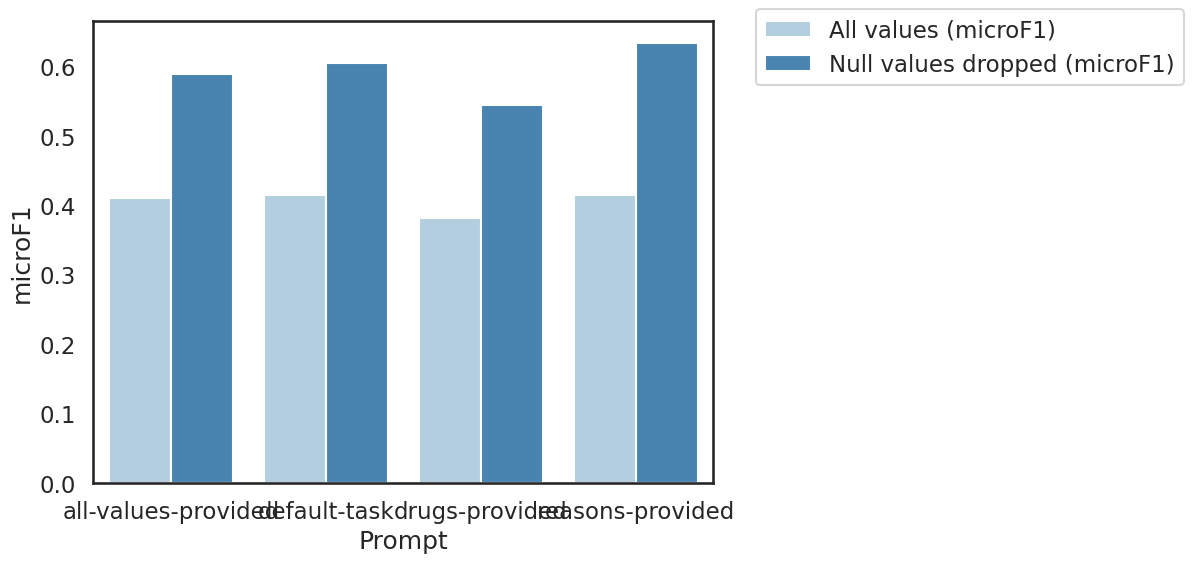

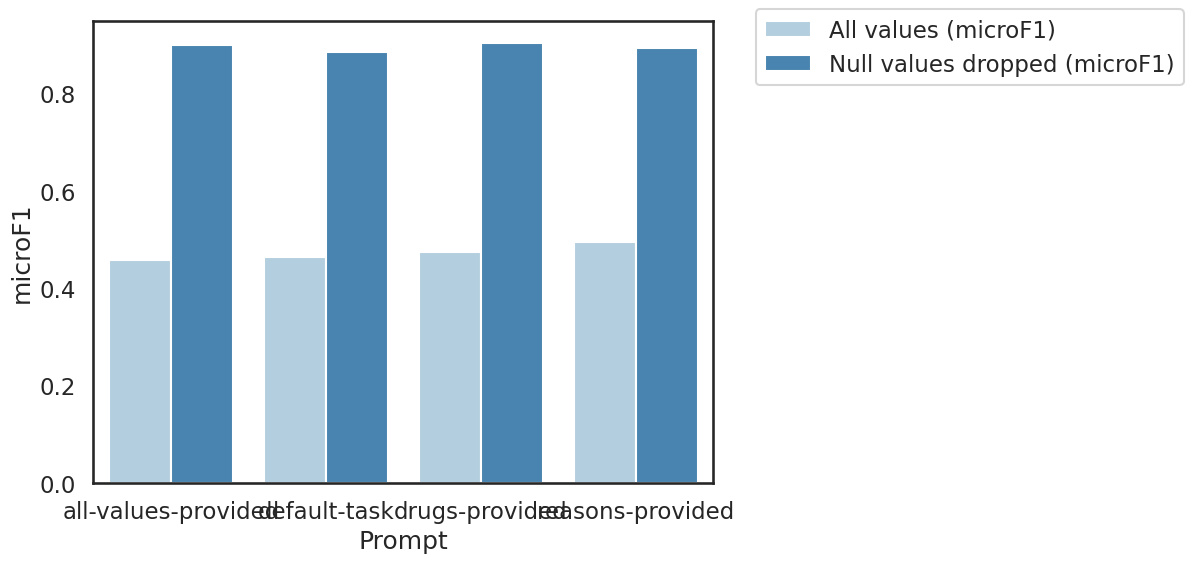

In [34]:
# GPT-4 propmpt development values
for task in ["last_TNFi_mapped_generic","new_TNFi_mapped_generic"]:
    fig,ax = plt.subplots(figsize=(8,6))
    plot_df = table_df[table_df["Model"] == "gpt-4-turbo-128k"]
    plot_df = plot_df[plot_df["Task"] == task]
    plot_df = plot_df.set_index(["Model", "Prompt", "Task"])[["All values (microF1)", "Null values dropped (microF1)"]].stack().reset_index()

    ax = sns.barplot(plot_df, x="Prompt", y=0,
                     hue="level_3",
                     ci=None, palette="Blues")
    ax.set_ylabel("microF1")
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05))
    ax.figure.savefig(f"./figures/ncdmard/FigureS1_Prompt-dev-gpt-4_{task}.pdf", bbox_inches="tight")

    

# Figure: Comparison of models to human annotation (Prompt dev)

In [2]:
### GPT4
# Create brand name -> generic mapping
all_drugs = pd.read_csv("./data/ncdmard/raw/med_mapping.csv")

all_drugs = all_drugs.dropna(subset=["drug_class"])
all_drugs = all_drugs[all_drugs["drug_class"].str.contains("anti-TNF")]

# Create brand name -> generic mapping
med_mapping = dict(zip(all_drugs["reference_brand_name"].str.lower(), all_drugs["generic_name"].str.lower()))
generic_dict = {b.lower():g.lower()+"-"+s.lower() for b,g,s in 
                zip(all_drugs["biosimilar_brand_name"], all_drugs["generic_name"], all_drugs["biosimilar_suffix"])
               if type(b)==str}
med_mapping.update(generic_dict)



In [3]:

### Automated evaluation
model = "gpt-4-turbo-128k"
date = "2024-02-21"

all_files = [f"./data/ncdmard/gpt4/prompt_dev/{date}_{model}_{task_name}_prompt_dev.csv" for task_name in ["default-task", "drugs-provided", "reasons-provided", "all-values-provided"]]

# Starling files
date = "2024-03-29"
task_name = "reasons-provided"

all_files.extend([f"./data/ncdmard/baseline/{date}_{model}_{task_name}_validation.csv" 
                  for model in ["starling-7b-beta", 
                                "starling-7b-alpha",
                               "OpenHermes-2.5-Mistral-7B",
                               "Snorkel-Mistral-PairRM-DPO",
                               "BioMistral-7B",
                               "Yi-6B-Chat",
                               "llama-2-7b-chat-hf"]])

date = "2024-04-21"
task_name = "reasons-provided"
all_files.extend([f"./data/ncdmard/baseline/{date}_{model}_{task_name}_validation.csv" 
                  for model in ["llama-3-8b-chat-hf",
                                "gemma-7b-it",
                               "zephyr-7b-gemma-v01",
                               "JSL-MedMNX-7B-SFT"]])


# compile values
all_metrics = []
all_responses = pd.DataFrame(columns=["note_deid_note_key"])

for file_path in all_files:
    pred_df = pd.read_csv(file_path, index_col=0)
    #valid_df = pd.read_parquet("./data/ncdmard/gpt4/validation.parquet.gzip")
    human_df = pd.read_csv("./data/ncdmard/annotation/annotation_set_MB.csv")
    
    # extract date, model_task_name
    file_name = file_path.split("/")[-1] 
    date = file_name.split("_")[0]
    model = file_name.split("_")[1]
    task_name = file_name.split("_")[2]
    
    #print(task_name, f"({model})")
    
    # Format values
    labels_df = pred_df.merge(human_df, left_index=True, right_on="note_deid_note_key", how="inner")
    labels_df["new_TNFi_mapped_generic"] = [None if type(s)!=str else medswitch.map_generic(s.lower().replace(" ", ""), med_mapping, return_value=False) for s in labels_df["new_TNFi"]]
    labels_df["last_TNFi_mapped_generic"] = [None if type(s)!=str else medswitch.map_generic(s.lower().replace(" ", ""), med_mapping, return_value=False) for s in labels_df["last_TNFi"]]
    if "reason_type_last_TNFi_stopped" in labels_df.columns:
        labels_df["reason_type_last_TNFi_stopped_clean"] = [None if type(s)!=str  
                                                            else s if s in ["Adverse event", "Drug resistance", 
                                                                        "Insurance/Cost", "Lack of efficacy",
                                                                        "Patient preference","Other", "NA"] 
                                                        else None for s in labels_df["reason_type_last_TNFi_stopped"]]
    # Get metrics
    for label_col, pred_col in {"TNFi started":"new_TNFi_mapped_generic", 
                                "TNFi stopped":"last_TNFi_mapped_generic",
                               "Reason type for stopping":"reason_type_last_TNFi_stopped"}.items():
        
        if pred_col in labels_df:
            # Clean up
            new_labels_df = labels_df.copy()
            new_labels_df[pred_col] = ["None" if type(s)!=str  
                                       else s for s in new_labels_df[pred_col]]
            new_labels_df[label_col] = ["None" if type(s)!=str  
                                       else s for s in new_labels_df[label_col]]

        
            labels = list(new_labels_df[label_col])
            preds = list(new_labels_df[pred_col])
            
            # Metrics
            acc_metrics = metrics.classification_metrics(preds, labels, average="micro")
            acc_metrics["n"] = len(labels)
            acc_metrics["dropna"] = dropna
            acc_metrics["task_name"] = task_name
            acc_metrics["label_col"] = pred_col
            acc_metrics["model"] = model
            acc_metrics["date"] = date
            all_metrics.append(acc_metrics)

            all_responses[pred_col+"_label"] = all_responses["note_deid_note_key"].map(dict(zip(labels_df["note_deid_note_key"], labels_df[label_col])))
        
all_metrics_df = pd.DataFrame.from_records(all_metrics)
all_metrics_df.to_csv("./figures/ncdmard/TableS1_prompt-dev-metrics_human-label.csv")

all_responses = all_responses.set_index("note_deid_note_key")
all_responses.to_csv("./figures/ncdmard/rawdata_FigureS2_value_concordance_human-label.csv")

# The reasons-provided task was selected because it had the best microF1 score on previous medication extraction
# And overall best microF1 score
# Same reasoning for selecting starling-7b-beta for the downstream reason extraction
print(all_metrics_df.groupby(["model", "task_name", "label_col"])["micro_F1"].mean())
print(all_metrics_df.groupby(["model", "task_name"])["micro_F1"].mean())

'''
model                       task_name            label_col                    
BioMistral-7B               reasons-provided     last_TNFi_mapped_generic         0.794521
                                                 new_TNFi_mapped_generic          0.691781
                                                 reason_type_last_TNFi_stopped    0.623288
JSL-MedMNX-7B-SFT           reasons-provided     last_TNFi_mapped_generic         0.852234
                                                 new_TNFi_mapped_generic          0.769759
                                                 reason_type_last_TNFi_stopped    0.706294
OpenHermes-2.5-Mistral-7B   reasons-provided     last_TNFi_mapped_generic         0.835616
                                                 new_TNFi_mapped_generic          0.753425
                                                 reason_type_last_TNFi_stopped    0.778947
Snorkel-Mistral-PairRM-DPO  reasons-provided     last_TNFi_mapped_generic         0.801370
                                                 new_TNFi_mapped_generic          0.719178
                                                 reason_type_last_TNFi_stopped    0.634686
Yi-6B-Chat                  reasons-provided     last_TNFi_mapped_generic         0.659794
                                                 new_TNFi_mapped_generic          0.719178
                                                 reason_type_last_TNFi_stopped    0.467626
gemma-7b-it                 reasons-provided     last_TNFi_mapped_generic         0.732877
                                                 new_TNFi_mapped_generic          0.602740
                                                 reason_type_last_TNFi_stopped    0.680412
gpt-4-turbo-128k            all-values-provided  last_TNFi_mapped_generic         0.680412
                                                 new_TNFi_mapped_generic          0.801370
                                                 reason_type_last_TNFi_stopped    0.825175
                            default-task         last_TNFi_mapped_generic         0.714777
                                                 new_TNFi_mapped_generic          0.760274
                            drugs-provided       last_TNFi_mapped_generic         0.664384
                                                 new_TNFi_mapped_generic          0.787671
                            reasons-provided     last_TNFi_mapped_generic         0.749141
                                                 new_TNFi_mapped_generic          0.773973
                                                 reason_type_last_TNFi_stopped    0.816901
llama-2-7b-chat-hf          reasons-provided     last_TNFi_mapped_generic         0.643836
                                                 new_TNFi_mapped_generic          0.575342
                                                 reason_type_last_TNFi_stopped    0.600707
llama-3-8b-chat-hf          reasons-provided     last_TNFi_mapped_generic         0.817869
                                                 new_TNFi_mapped_generic          0.753425
                                                 reason_type_last_TNFi_stopped    0.822695
starling-7b-alpha           reasons-provided     last_TNFi_mapped_generic         0.897260
                                                 new_TNFi_mapped_generic          0.753425
                                                 reason_type_last_TNFi_stopped    0.703833
starling-7b-beta            reasons-provided     last_TNFi_mapped_generic         0.876712
                                                 new_TNFi_mapped_generic          0.787671
                                                 reason_type_last_TNFi_stopped    0.637993
zephyr-7b-gemma-v01         reasons-provided     last_TNFi_mapped_generic         0.698630
                                                 new_TNFi_mapped_generic          0.760274
                                                 reason_type_last_TNFi_stopped    0.659420
Name: micro_F1, dtype: float64

model                       task_name          
BioMistral-7B               reasons-provided       0.703196
JSL-MedMNX-7B-SFT           reasons-provided       0.776096
OpenHermes-2.5-Mistral-7B   reasons-provided       0.789329
Snorkel-Mistral-PairRM-DPO  reasons-provided       0.718411
Yi-6B-Chat                  reasons-provided       0.615533
gemma-7b-it                 reasons-provided       0.672010
gpt-4-turbo-128k            all-values-provided    0.768986
                            default-task           0.737525
                            drugs-provided         0.726027
                            reasons-provided       0.780005
llama-2-7b-chat-hf          reasons-provided       0.606628
llama-3-8b-chat-hf          reasons-provided       0.797996
starling-7b-alpha           reasons-provided       0.784839
starling-7b-beta            reasons-provided       0.767459
zephyr-7b-gemma-v01         reasons-provided       0.706108
Name: micro_F1, dtype: float64
'''




['./data/ncdmard/gpt4/prompt_dev/2024-02-21_gpt-4-turbo-128k_default-task_prompt_dev.csv',
 './data/ncdmard/gpt4/prompt_dev/2024-02-21_gpt-4-turbo-128k_drugs-provided_prompt_dev.csv',
 './data/ncdmard/gpt4/prompt_dev/2024-02-21_gpt-4-turbo-128k_reasons-provided_prompt_dev.csv',
 './data/ncdmard/gpt4/prompt_dev/2024-02-21_gpt-4-turbo-128k_all-values-provided_prompt_dev.csv',
 './data/ncdmard/baseline/2024-03-29_starling-7b-beta_reasons-provided_validation.csv',
 './data/ncdmard/baseline/2024-03-29_starling-7b-alpha_reasons-provided_validation.csv',
 './data/ncdmard/baseline/2024-03-29_OpenHermes-2.5-Mistral-7B_reasons-provided_validation.csv',
 './data/ncdmard/baseline/2024-03-29_Snorkel-Mistral-PairRM-DPO_reasons-provided_validation.csv',
 './data/ncdmard/baseline/2024-03-29_BioMistral-7B_reasons-provided_validation.csv',
 './data/ncdmard/baseline/2024-03-29_Yi-6B-Chat_reasons-provided_validation.csv',
 './data/ncdmard/baseline/2024-03-29_llama-2-7b-chat-hf_reasons-provided_validation.

# Figure: Pairwise win rates between models (against human annotation)


In [23]:
# Load values
all_responses = pd.read_csv("./figures/ncdmard/rawdata_FigureS2_value_concordance.csv", index_col=0)
all_responses = all_responses.replace(np.nan, "None")

all_metrics = pd.read_csv("./figures/ncdmard/TableS1_prompt-dev-metrics.csv", index_col=0)
all_metrics = all_metrics[~all_metrics["dropna"] & (all_metrics["task_name"]=="reasons-provided")]

models = ['gpt-4-turbo-128k',
          'llama-3-8b-chat-hf',
          'starling-7b-beta',
           "JSL-MedMNX-7B-SFT",
          'OpenHermes-2.5-Mistral-7B',
          'starling-7b-alpha',
          'Yi-6B-Chat',
          'Snorkel-Mistral-PairRM-DPO',
          'zephyr-7b-gemma-v01',
          'BioMistral-7B',
          'gemma-7b-it',
          'llama-2-7b-chat-hf',
         'human-label']

def calculate_win(model_A,
                  model_B,
                  label,
                  model_A_win_value=1, 
                  model_B_win_value=-1,
                 tie_value=0):
    
    #TODO: figure out if tie values are correct
    
    if model_A == model_B == label:
        return tie_value # both right
    
    if model_A == label:
        return model_A_win_value
    if model_B == label:
        return model_B_win_value
    
    return tie_value # both wrong

compare_dict = defaultdict(dict)
elo_wins_dict = []

for col_type in ["reason_type_last_TNFi_stopped_clean",
                 "new_TNFi_mapped_generic",
                 "last_TNFi_mapped_generic"]:
    for model1 in models:
        for model2 in models:
            curr_responses = all_responses.filter(regex=col_type)
            
            # Calculate accuracy of model 1 == model 2
            total = len(curr_responses)
            em_count = len(curr_responses[curr_responses[col_type+"_"+model1] == curr_responses[col_type+"_"+model2]])
            compare_dict[model1][model2] = em_count / total
            
            # Calculate pairwise win scores
            if col_type!="reason_type_last_TNFi_stopped_clean": 
                # TO benchmark against GPT4, use "gpt-4-turbo-128k" instead of "_label"
                # Figure 2 is benchmarking against GPT-4 labels even if ground truth labels are available
                curr_responses[col_type+"_winner"] = curr_responses.apply(lambda row: calculate_win(row[col_type+"_"+model1], 
                                                                    row[col_type+"_"+model2],
                                                                    label=row[col_type+"_human-label"]), axis=1)
                
                elo_wins_dict.append({"model_A":model1,
                                       "model_B":model2,
                                       "label_col":col_type,
                                       "model_A_win_rate":sum(curr_responses[col_type+"_winner"]==1) / len(curr_responses),
                                     "model_A_tie_rate":sum(curr_responses[col_type+"_winner"]==0) / len(curr_responses),
                                      "model_A_win_or_tie_rate":sum(curr_responses[col_type+"_winner"] != -1) / len(curr_responses)})
                #print(model1, model2, elo_wins_dict[model1][model2])
            else:
                # TO benchmark against GPT4, use "gpt-4-turbo-128k" instead of "_labels"
                # Figure 2C is benchmarking against GPT4 (no label col)
                curr_responses[col_type+"_winner"] = curr_responses.apply(lambda row: calculate_win(row[col_type+"_"+model1], 
                                                                    row[col_type+"_"+model2],
                                                                    label=row[col_type+"_human-label"]), axis=1)
                
                elo_wins_dict.append({"model_A":model1,
                                       "model_B":model2,
                                       "label_col":col_type,
                                       "model_A_win_rate":sum(curr_responses[col_type+"_winner"]==1) / len(curr_responses),
                                     "model_A_tie_rate":sum(curr_responses[col_type+"_winner"]==0) / len(curr_responses),
                                      "model_A_win_or_tie_rate":sum(curr_responses[col_type+"_winner"] != -1) / len(curr_responses)})
                #print(model1, model2, elo_wins_dict[model1][model2])
        
    ## Figure S2: Model concordance on reason type extraction
    # Plot clustermaps
    compare_df = pd.DataFrame(compare_dict)
    compare_df.to_csv(f"./figures/ncdmard/rawdata_FigureS2_{col_type}_pairwise_concordance.csv")
    benchmark_plot.overall_modelxmodel_clustermap(compare_df,
                                       metric=col_type,
                                       out_fpath=f"./figures/ncdmard/FigureS2_{col_type}_concordance_clustermap.pdf",
                                        cmap="RdBu_r",
                                         figsize=(8,8),)
    
    # Add mean and plot dotplots
    compare_df = compare_df.stack().reset_index()
    compare_df.columns = ["Model1", "Model2", "concordance_"+col_type]
    curr_metrics = all_metrics[all_metrics["label_col"]==col_type]
    if len(curr_metrics)>0:
        curr_metrics = dict(zip(curr_metrics["model"], curr_metrics["micro_F1"]))
        compare_df["mean_"+col_type] = compare_df["Model1"].map(curr_metrics)
        
        benchmark_plot.overall_modelxmodel_dotplot(compare_df,
                                   metric=col_type,
                                   out_fpath=f"./figures/ncdmard/FigureS2_{col_type}_dotplot.pdf",
                                     figsize=(8,6))
        compare_df.to_csv(f"./figures/ncdmard/rawdata_FigureS2_{col_type}.csv")

elo_scores_df = pd.DataFrame.from_records(elo_wins_dict)
elo_scores_df.to_csv("./figures/ncdmard/rawdata_Figure2_pairwise_win_scores.csv")




In [ ]:
## FIGURE 2: Pairwise win scores
# Figure 2: Get scores and write to figure
elo_scores_df= pd.read_csv("./figures/ncdmard/rawdata_Figure2_pairwise_win_scores.csv", index_col=0)
#elo_scores_df["model_A_win_or_tie_rate"] = elo_scores_df["model_A_win_rate"] + elo_scores_df["model_A_tie_rate"]
label_dict = {"new_TNFi_mapped_generic":"New TNFi Started",
              "last_TNFi_mapped_generic":"Last TNFi Stopped",
             "reason_type_last_TNFi_stopped_clean":"Reason for stopping TNFi vs GPT4"}
for label_col in label_dict:
    for win_type in ["model_A_win_rate", "model_A_tie_rate", "model_A_win_or_tie_rate"]:

        score_sub_df = elo_scores_df[elo_scores_df["label_col"]==label_col]
        score_sub_df = score_sub_df.pivot_table(index="model_A",
                                                columns = "model_B",
                                                values=win_type,
                                                sort=False)
        
        if label_col == "reason_type_last_TNFi_stopped_clean": # remove GPT4
            del score_sub_df["human-label"]
            score_sub_df = score_sub_df.drop("human-label", axis=0)
            
        if win_type == "model_A_tie_rate":    
            score_sub_df = score_sub_df.where(np.tril(np.ones(score_sub_df.shape)).astype(bool))

        fig = benchmark_plot.visualize_pairwise_win_fraction(score_sub_df,
                                              title=label_dict[label_col].replace('1','A')+ f" ({win_type})",
                                              max_num_models=30)
        fig.write_image(f"./figures/ncdmard/Figure2_human-label_{label_col.replace('1','A')}-{win_type}.pdf")
        
# OVERALL WIN RATES
for win_type in ["model_A_win_rate", "model_A_tie_rate", "model_A_win_or_tie_rate"]:
    score_sub_df = elo_scores_df.pivot_table(index="model_A",
                                                    columns = "model_B",
                                                    values=win_type,
                                                    sort=False)
    

    if label_col == "reason_type_last_TNFi_stopped_clean": # remove GPT4
        del score_sub_df["human-label"]
        score_sub_df = score_sub_df.drop("human-label", axis=0)

    fig = benchmark_plot.visualize_pairwise_win_fraction(score_sub_df,
                                          title=f"Overall {win_type}",
                                          max_num_models=30)
    fig.write_image(f"./figures/ncdmard/Figure2_human-label_OVERALL_{win_type}.pdf")

# Save mean values
means_df = elo_scores_df.groupby("model_A")[["model_A_win_rate", "model_A_tie_rate", "model_A_win_or_tie_rate"]].mean()
std_df = elo_scores_df.groupby("model_A")[["model_A_win_rate", "model_A_tie_rate", "model_A_win_or_tie_rate"]].std()

elo_scores_df = means_df.merge(std_df, left_index=True, right_index=True, how="inner", suffixes=["_mean", "_std"])
elo_scores_df.to_csv(f"./figures/ncdmard/rawdata_Figure2_means-std_human-label.csv")



# Figure 2: Pairwise win rates between models (Silver-standard labels)


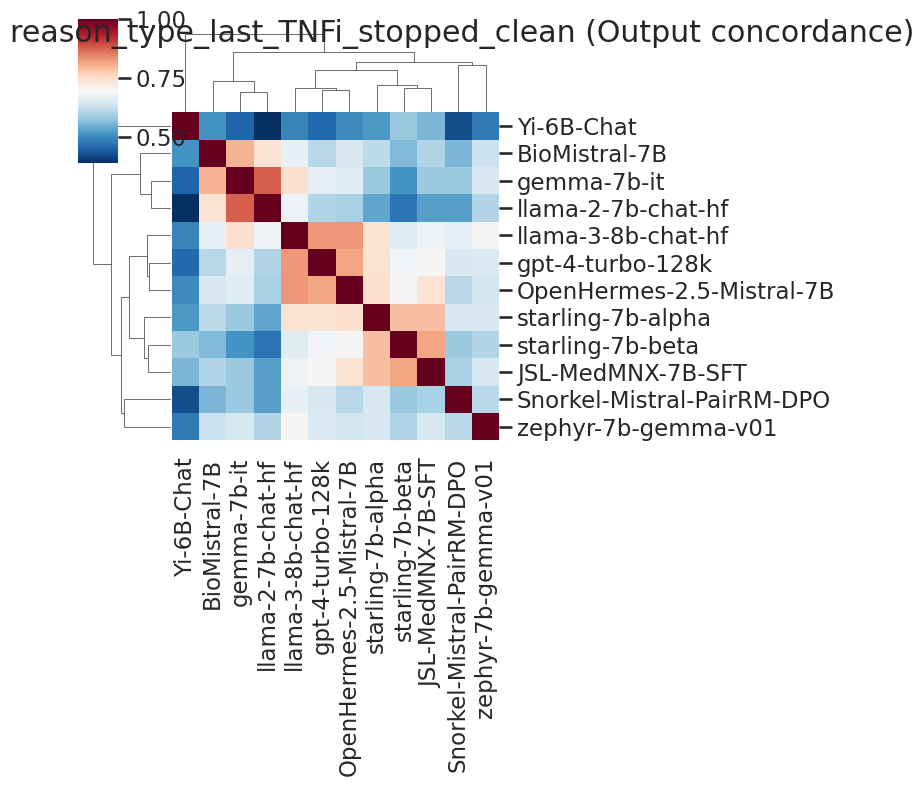

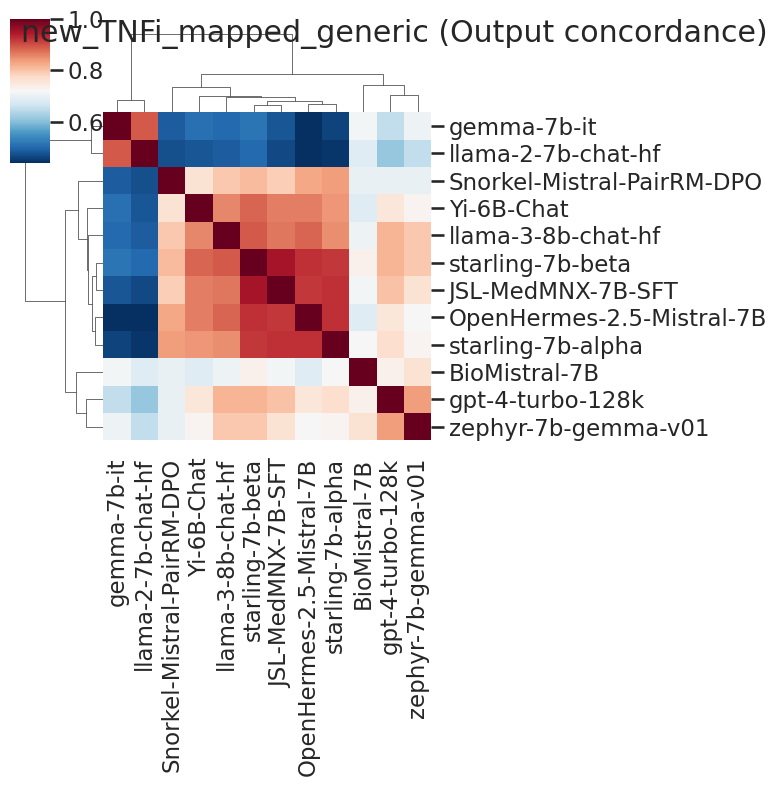

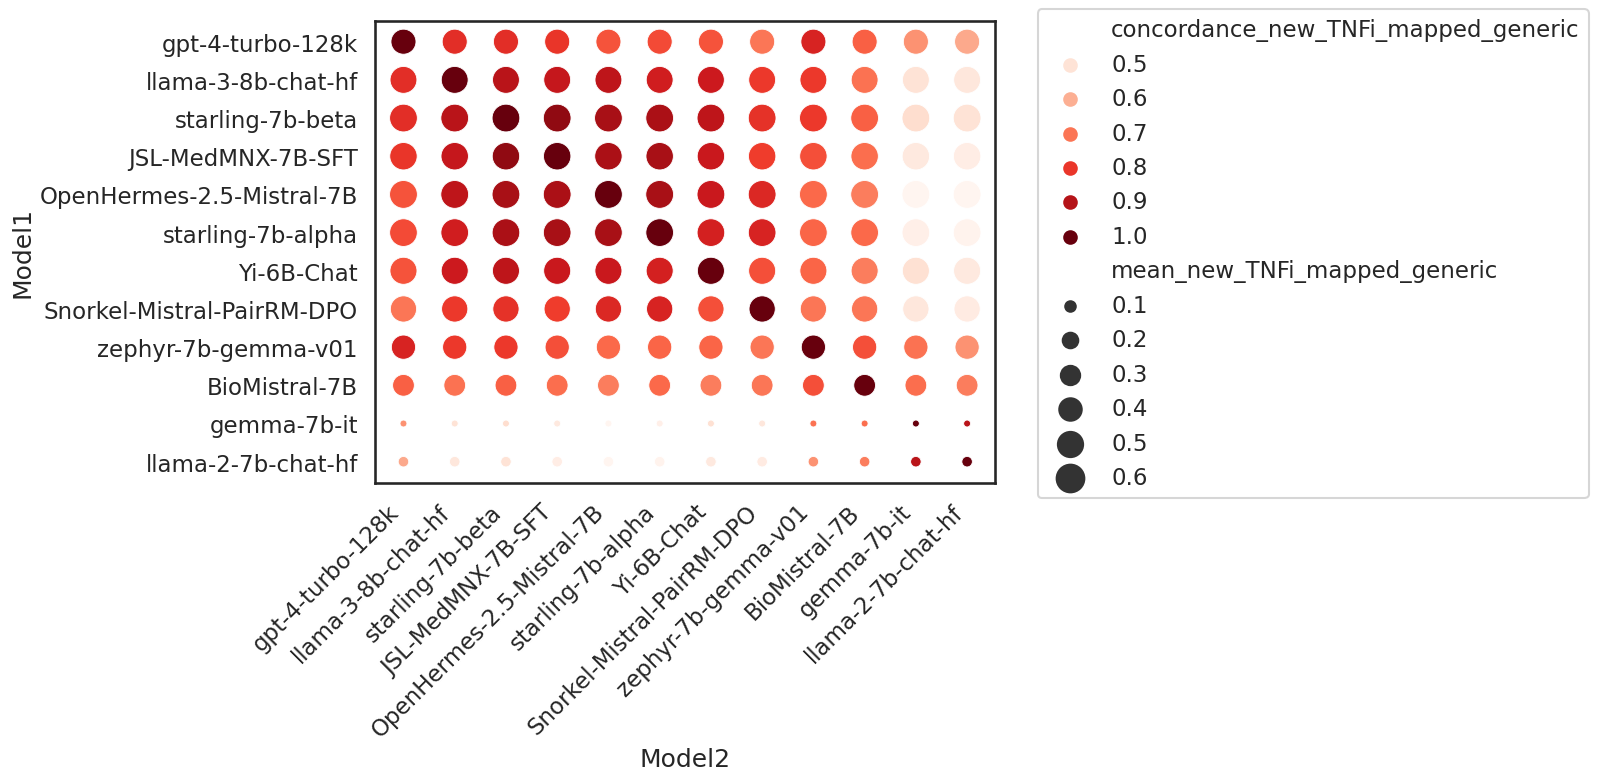

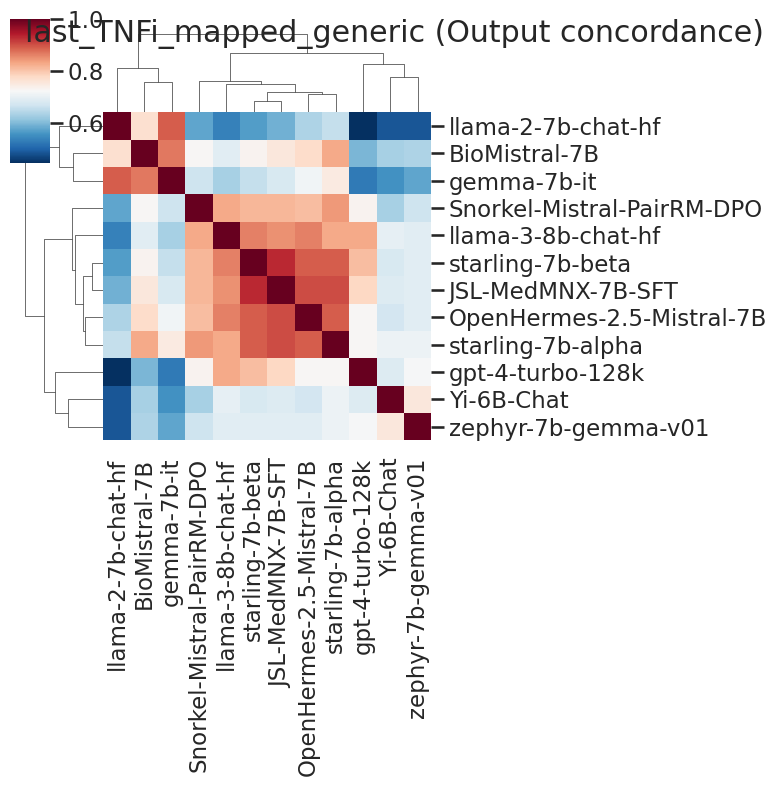

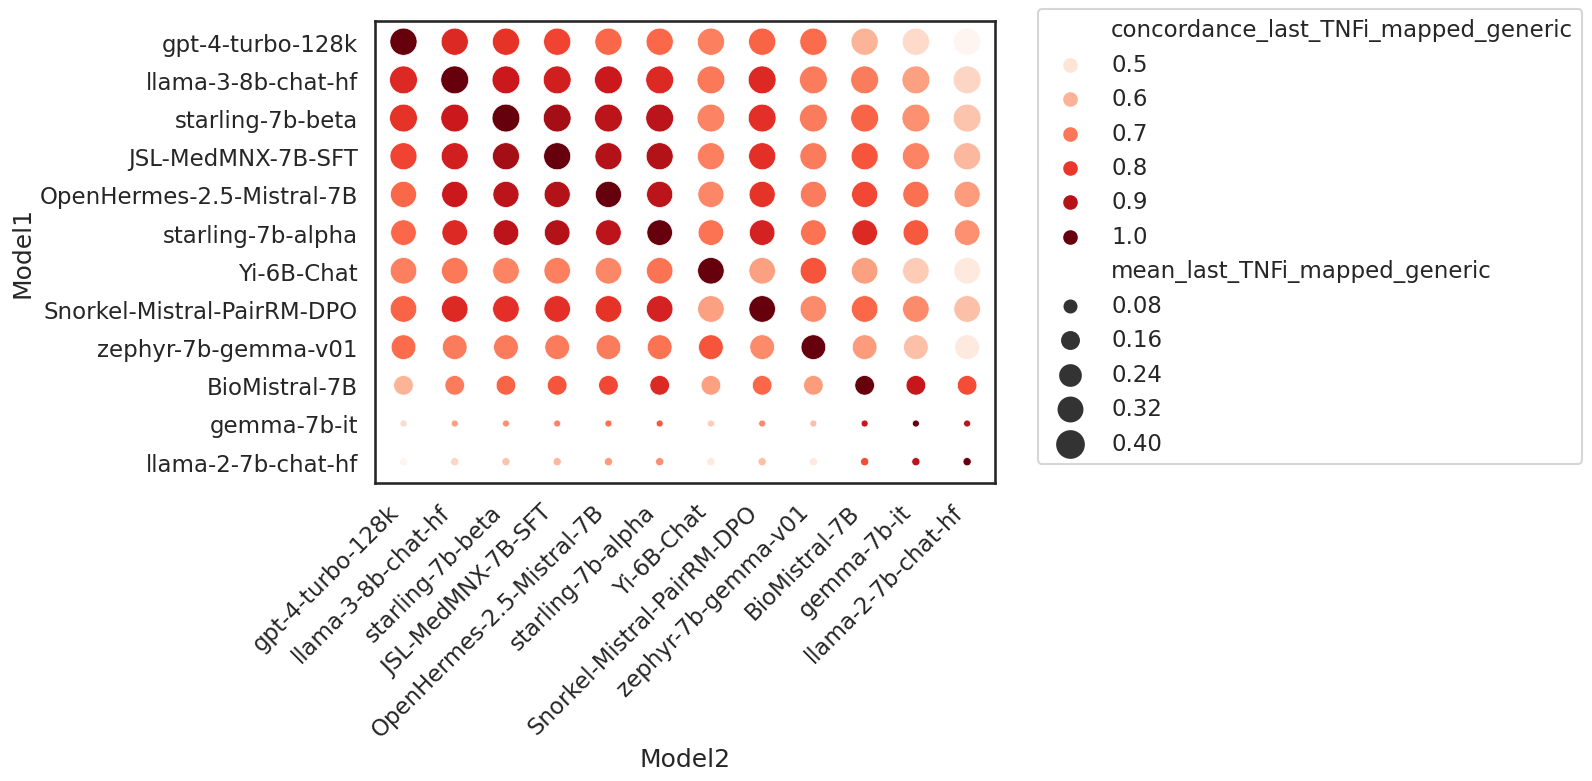

In [64]:
# Load values
all_responses = pd.read_csv("./figures/ncdmard/rawdata_Figure2_value_concordance.csv", index_col=0)
all_responses = all_responses.replace(np.nan, "None")

all_metrics = pd.read_csv("./figures/ncdmard/TableS1_prompt-dev-metrics.csv", index_col=0)
all_metrics = all_metrics[~all_metrics["dropna"] & (all_metrics["task_name"]=="reasons-provided")]

models = ['gpt-4-turbo-128k',
          'llama-3-8b-chat-hf',
          'starling-7b-beta',
           "JSL-MedMNX-7B-SFT",
          'OpenHermes-2.5-Mistral-7B',
          'starling-7b-alpha',
          'Yi-6B-Chat',
          'Snorkel-Mistral-PairRM-DPO',
          'zephyr-7b-gemma-v01',
          'BioMistral-7B',
          'gemma-7b-it',
          'llama-2-7b-chat-hf']

def calculate_win(model_A,
                  model_B,
                  label,
                  model_A_win_value=1, 
                  model_B_win_value=-1,
                 tie_value=0):
    
    #TODO: figure out if tie values are correct
    
    if model_A == model_B == label:
        return tie_value # both right
    
    if model_A == label:
        return model_A_win_value
    if model_B == label:
        return model_B_win_value
    
    return tie_value # both wrong

compare_dict = defaultdict(dict)
elo_wins_dict = []

for col_type in ["reason_type_last_TNFi_stopped_clean",
                 "new_TNFi_mapped_generic",
                 "last_TNFi_mapped_generic"]:
    for model1 in models:
        for model2 in models:
            curr_responses = all_responses.filter(regex=col_type)
            
            # Calculate accuracy of model 1 == model 2
            total = len(curr_responses)
            em_count = len(curr_responses[curr_responses[col_type+"_"+model1] == curr_responses[col_type+"_"+model2]])
            compare_dict[model1][model2] = em_count / total
            
            # Calculate pairwise win scores
            if col_type!="reason_type_last_TNFi_stopped_clean": 
                # TO benchmark against GPT4, use "gpt-4-turbo-128k" instead of "_label"
                # Figure 2 is benchmarking against GPT-4 labels even if ground truth labels are available
                curr_responses[col_type+"_winner"] = curr_responses.apply(lambda row: calculate_win(row[col_type+"_"+model1], 
                                                                    row[col_type+"_"+model2],
                                                                    label=row[col_type+"_gpt-4-turbo-128k"]), axis=1)
                
                elo_wins_dict.append({"model_A":model1,
                                       "model_B":model2,
                                       "label_col":col_type,
                                       "model_A_win_rate":sum(curr_responses[col_type+"_winner"]==1) / len(curr_responses),
                                     "model_A_tie_rate":sum(curr_responses[col_type+"_winner"]==0) / len(curr_responses),
                                      "model_A_win_or_tie_rate":sum(curr_responses[col_type+"_winner"] != -1) / len(curr_responses)})
                #print(model1, model2, elo_wins_dict[model1][model2])
            else:
                # TO benchmark against GPT4, use "gpt-4-turbo-128k" instead of "_labels"
                # Figure 2C is benchmarking against GPT4 (no label col)
                curr_responses[col_type+"_winner"] = curr_responses.apply(lambda row: calculate_win(row[col_type+"_"+model1], 
                                                                    row[col_type+"_"+model2],
                                                                    label=row[col_type+"_gpt-4-turbo-128k"]), axis=1)
                
                elo_wins_dict.append({"model_A":model1,
                                       "model_B":model2,
                                       "label_col":col_type,
                                       "model_A_win_rate":sum(curr_responses[col_type+"_winner"]==1) / len(curr_responses),
                                     "model_A_tie_rate":sum(curr_responses[col_type+"_winner"]==0) / len(curr_responses),
                                      "model_A_win_or_tie_rate":sum(curr_responses[col_type+"_winner"] != -1) / len(curr_responses)})
                #print(model1, model2, elo_wins_dict[model1][model2])
        
    ## Figure S2: Model concordance on reason type extraction
    # Plot clustermaps
    compare_df = pd.DataFrame(compare_dict)
    compare_df.to_csv(f"./figures/ncdmard/rawdata_FigureS2_{col_type}_pairwise_concordance.csv")
    plot_overall_modelxmodel_clustermap(compare_df,
                                       metric=col_type,
                                       out_fpath=f"./figures/ncdmard/FigureS2_{col_type}_concordance_clustermap.pdf",
                                        cmap="RdBu_r",
                                         figsize=(8,8),)
    
    # Add mean and plot dotplots
    compare_df = compare_df.stack().reset_index()
    compare_df.columns = ["Model1", "Model2", "concordance_"+col_type]
    curr_metrics = all_metrics[all_metrics["label_col"]==col_type]
    if len(curr_metrics)>0:
        curr_metrics = dict(zip(curr_metrics["model"], curr_metrics["micro_F1"]))
        compare_df["mean_"+col_type] = compare_df["Model1"].map(curr_metrics)
        
        plot_overall_modelxmodel_dotplot(compare_df,
                                   metric=col_type,
                                   out_fpath=f"./figures/ncdmard/FigureS2_{col_type}_dotplot.pdf",
                                     figsize=(8,6))
        compare_df.to_csv(f"./figures/ncdmard/rawdata_FigureS2_{col_type}.csv")

elo_scores_df = pd.DataFrame.from_records(elo_wins_dict)
elo_scores_df.to_csv("./figures/ncdmard/rawdata_Figure2_pairwise_win_scores.csv")



In [84]:
## Mean concordance scores (vs GPT-4)
all_concord_df = pd.DataFrame()
for col_type in ["reason_type_last_TNFi_stopped_clean",
                 "new_TNFi_mapped_generic",
                 "last_TNFi_mapped_generic"]:
    concord_df = pd.read_csv(f"./figures/ncdmard/rawdata_FigureS2_{col_type}_pairwise_concordance.csv", index_col=0)
    concord_df = concord_df[["gpt-4-turbo-128k"]]
    concord_df.columns = [col_type]
    all_concord_df = concord_df.merge(all_concord_df, right_index=True, left_index=True, how="left")
    
all_concord_df["mean"] = all_concord_df.mean(axis=1)
all_concord_df["std"] = all_concord_df.std(axis=1)
all_concord_df.to_csv("./figures/ncdmard/TableS6_gpt-4_concordance.csv")


In [104]:
## FIGURE 2: Pairwise win scores
def visualize_pairwise_win_fraction(elo_scores, title, max_num_models=30):
    #row_beats_col = compute_pairwise_win_fraction(battles, max_num_models)
    fig = px.imshow(elo_scores, color_continuous_scale='RdBu_r', # Blues, tempo
                    text_auto=".2f", title=title,)
    fig.update_layout(xaxis_title="Model B: Loser",
                  yaxis_title="Model A: Winner",
                  xaxis_side="bottom",
                      height=900,
                      width=900,
                  title_y=0.89,
                      title_x=0.55)
    fig.update_xaxes(tickangle=-30)
    fig.update_traces(hovertemplate=
                  "Model A: %{y}<br>Model B: %{x}<br>Fraction of A Wins: %{z}<extra></extra>")

    return fig

# Figure 2: Get scores and write to figure
elo_scores_df= pd.read_csv("./figures/ncdmard/rawdata_Figure2_pairwise_win_scores.csv", index_col=0)
#elo_scores_df["model_A_win_or_tie_rate"] = elo_scores_df["model_A_win_rate"] + elo_scores_df["model_A_tie_rate"]
label_dict = {"new_TNFi_mapped_generic":"New TNFi Started",
              "last_TNFi_mapped_generic":"Last TNFi Stopped",
             "reason_type_last_TNFi_stopped_clean":"Reason for stopping TNFi vs GPT4"}
for label_col in label_dict:
    for win_type in ["model_A_win_rate", "model_A_tie_rate", "model_A_win_or_tie_rate"]:

        score_sub_df = elo_scores_df[elo_scores_df["label_col"]==label_col]
        score_sub_df = score_sub_df.pivot_table(index="model_A",
                                                columns = "model_B",
                                                values=win_type,
                                                sort=False)
        
        if label_col == "reason_type_last_TNFi_stopped_clean": # remove GPT4
            del score_sub_df["gpt-4-turbo-128k"]
            score_sub_df = score_sub_df.drop("gpt-4-turbo-128k", axis=0)
            
        if win_type == "model_A_tie_rate":    
            score_sub_df = score_sub_df.where(np.tril(np.ones(score_sub_df.shape)).astype(bool))

        fig = visualize_pairwise_win_fraction(score_sub_df,
                                              title=label_dict[label_col].replace('1','A')+ f" ({win_type})",
                                              max_num_models=30)
        fig.write_image(f"./figures/ncdmard/Figure2_{label_col.replace('1','A')}-{win_type}.pdf")
        
# OVERALL WIN RATES
for win_type in ["model_A_win_rate", "model_A_tie_rate", "model_A_win_or_tie_rate"]:
    score_sub_df = elo_scores_df.pivot_table(index="model_A",
                                                    columns = "model_B",
                                                    values=win_type,
                                                    sort=False)
    

    if label_col == "reason_type_last_TNFi_stopped_clean": # remove GPT4
        del score_sub_df["gpt-4-turbo-128k"]
        score_sub_df = score_sub_df.drop("gpt-4-turbo-128k", axis=0)

    fig = visualize_pairwise_win_fraction(score_sub_df,
                                          title=f"Overall {win_type}",
                                          max_num_models=30)
    fig.write_image(f"./figures/ncdmard/Figure2_OVERALL_{win_type}.pdf")

# Save mean values
means_df = elo_scores_df.groupby("model_A")[["model_A_win_rate", "model_A_tie_rate", "model_A_win_or_tie_rate"]].mean()
std_df = elo_scores_df.groupby("model_A")[["model_A_win_rate", "model_A_tie_rate", "model_A_win_or_tie_rate"]].std()

elo_scores_df = means_df.merge(std_df, left_index=True, right_index=True, how="inner", suffixes=["_mean", "_std"])
elo_scores_df.to_csv(f"./figures/ncdmard/rawdata_Figure2_means-std.csv")



# Table S2: Test set evaluation

In [ ]:
### Starling & GPT4
# Create brand name -> generic mapping
all_drugs = pd.read_csv("./data/ncdmard/raw/med_mapping.csv")

all_drugs = all_drugs.dropna(subset=["drug_class"])
all_drugs = all_drugs[all_drugs["drug_class"].str.contains("anti-TNF")]

# Create brand name -> generic mapping
med_mapping = dict(zip(all_drugs["reference_brand_name"].str.lower(), all_drugs["generic_name"].str.lower()))
generic_dict = {b.lower():g.lower()+"-"+s.lower() for b,g,s in 
                zip(all_drugs["biosimilar_brand_name"], all_drugs["generic_name"], all_drugs["biosimilar_suffix"])
               if type(b)==str}
med_mapping.update(generic_dict)

### Automated evaluation
all_metrics = []
for file_path in ['./data/ncdmard/baseline/2024-03-29_starling-7b-beta_reasons-provided_test.csv',
                 './data/ncdmard/gpt4/2024-03-30_gpt-4-turbo-128k_reasons-provided_test.csv']:

    testing = pd.read_csv(file_path, index_col=0)
    valid_df = pd.read_parquet("./data/ncdmard/gpt4/test.parquet.gzip")
    
    # extract date, model_task_name
    file_name = file_path.split("/")[-1] 
    date = file_name.split("_")[0]
    model = file_name.split("_")[1]
    task_name = file_name.split("_")[2]
    
    print(task_name, f"({model})")
    # Format values
    labels_df = testing.merge(valid_df, left_index=True, right_on="note_deid_note_key", how="inner")
    labels_df["new_TNFi_mapped_generic"] = [None if type(s)!=str else medswitch.map_generic(s.lower().replace(" ", ""), med_mapping, return_value=False) for s in labels_df["new_TNFi"]]
    labels_df["last_TNFi_mapped_generic"] = [None if type(s)!=str else medswitch.map_generic(s.lower().replace(" ", ""), med_mapping, return_value=False) for s in labels_df["last_TNFi"]]
    labels_df["prev_medication_mapped_generic"] = [None if type(s)!=str else medswitch.map_generic(s.lower().replace(" ", ""), med_mapping, return_value=False) for s in labels_df["prev_medication"]]

    # Get metrics
    for dropna in [True, False]:
        for label_col, pred_col in {"mapped_med_generic_clean":"new_TNFi_mapped_generic", 
                                    "prev_medication_mapped_generic":"last_TNFi_mapped_generic"}.items():
            # Drop NA values
            if dropna:
                new_labels_df = labels_df.dropna(subset=[pred_col, label_col], how="any")
            else:
                new_labels_df = labels_df.copy()
                new_labels_df[pred_col] = ["None" if type(s)!=str  
                                           else s for s in new_labels_df[pred_col]]
                new_labels_df[label_col] = ["None" if type(s)!=str  
                                           else s for s in new_labels_df[label_col]]

            labels = list(new_labels_df[label_col])
            preds = list(new_labels_df[pred_col])

            acc_metrics = metrics.classification_metrics(preds, labels, average="micro")
            acc_metrics["n"] = len(labels)
            acc_metrics["dropna"] = dropna
            acc_metrics["task_name"] = task_name
            acc_metrics["label_col"] = label_col
            acc_metrics["model"] = model
            acc_metrics["date"] = date
            all_metrics.append(acc_metrics)

all_metrics_df = pd.DataFrame.from_records(all_metrics)       
all_metrics_df.to_csv("./figures/ncdmard/TableS2_test-eval-metrics_starling.csv")


In [ ]:
all_metrics_df


# Table 2: Reasons for switching

reason_type_last_TNFi_stopped
Lack of efficacy      568
Adverse event         135
Insurance/Cost        108
Patient preference     82
Other                  54
Drug resistance        51
Name: count, dtype: int64
reason_type_last_TNFi_stopped
Lack of efficacy      0.569138
Adverse event         0.135271
Insurance/Cost        0.108216
Patient preference    0.082164
Other                 0.054108
Drug resistance       0.051102
Name: proportion, dtype: float64
reason_type_last_TNFi_stopped
Adverse event         620
Lack of efficacy      340
Insurance/Cost        203
Drug resistance        96
Patient preference     85
Other                   1
Name: count, dtype: int64
reason_type_last_TNFi_stopped
Adverse event         0.460967
Lack of efficacy      0.252788
Insurance/Cost        0.150929
Drug resistance       0.071375
Patient preference    0.063197
Other                 0.000743
Name: proportion, dtype: float64


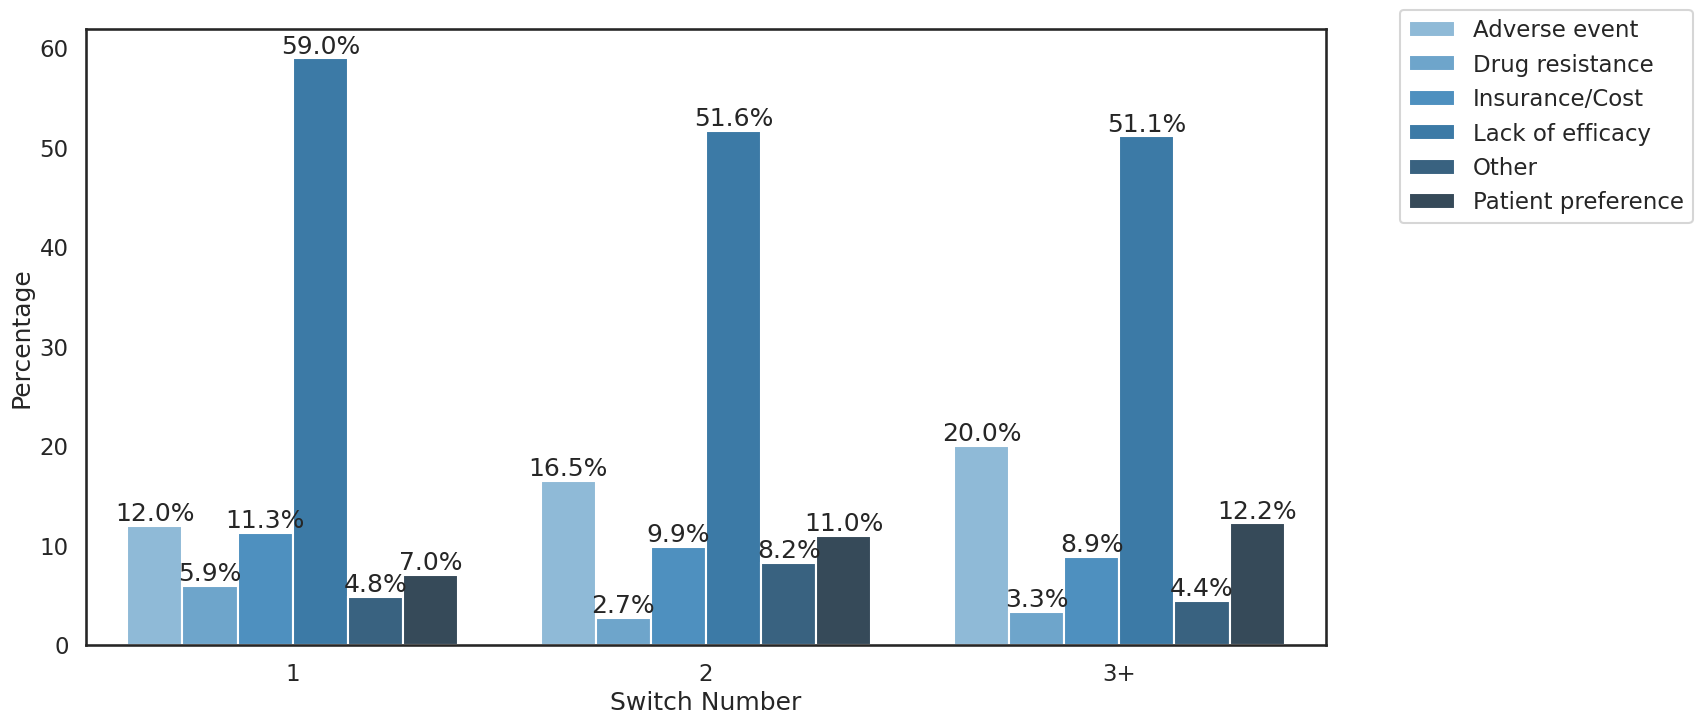

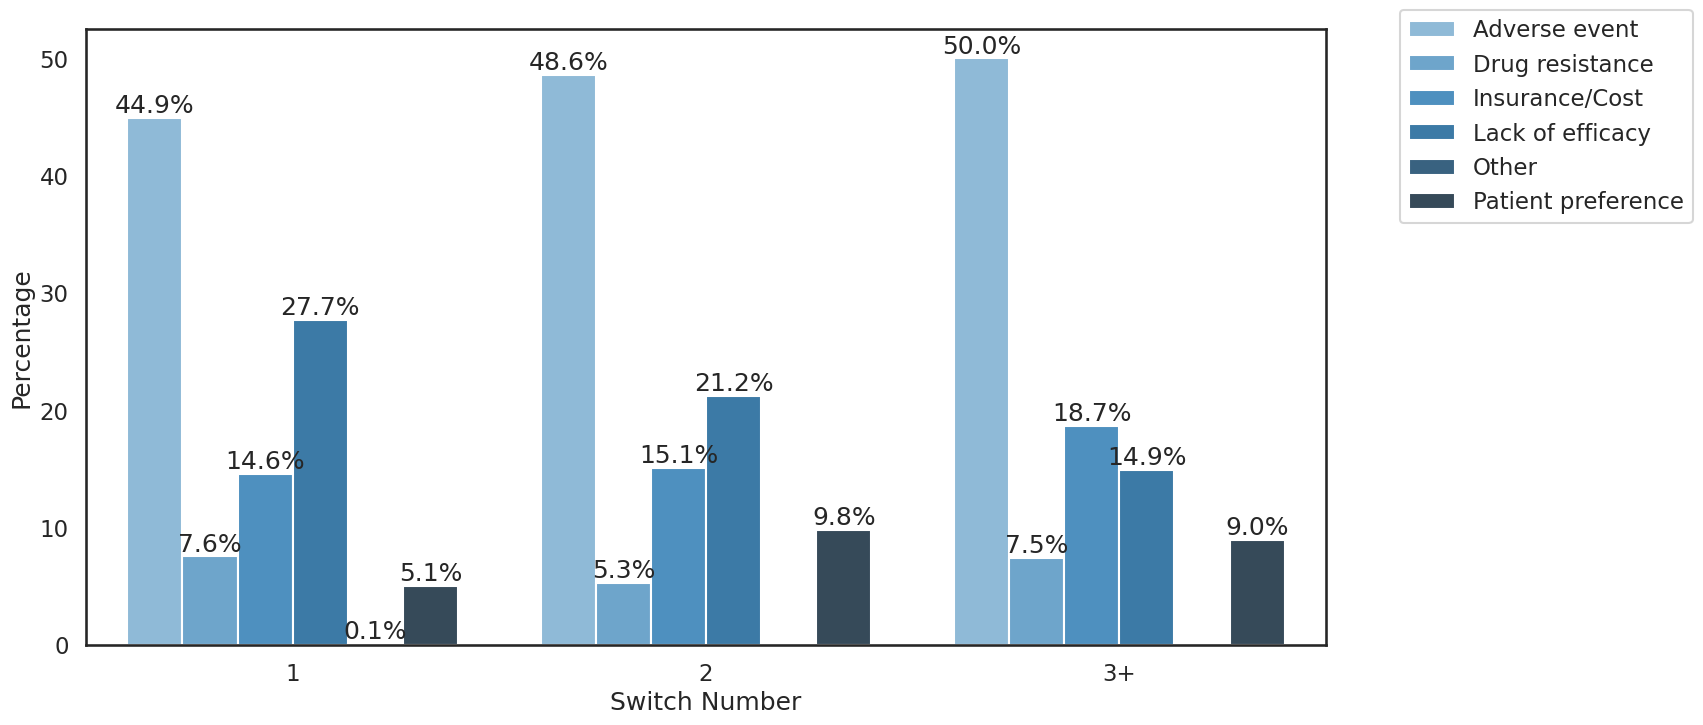

In [79]:
import plotly.graph_objects as go

### GPT4
# Load all data (development & test)
# Create brand name -> generic mapping
all_drugs = pd.read_csv("./data/ncdmard/raw/med_mapping.csv")

all_drugs = all_drugs.dropna(subset=["drug_class"])
all_drugs = all_drugs[all_drugs["drug_class"].str.contains("anti-TNF")]

# Create brand name -> generic mapping
med_mapping = dict(zip(all_drugs["reference_brand_name"].str.lower(), all_drugs["generic_name"].str.lower()))
generic_dict = {b.lower():g.lower()+"-"+s.lower() for b,g,s in 
                zip(all_drugs["biosimilar_brand_name"], all_drugs["generic_name"], all_drugs["biosimilar_suffix"])
               if type(b)==str}
med_mapping.update(generic_dict)

# Load diangosis data
diagnosis_map_df = pd.read_csv("./data/ncdmard/medications_with_diagnosis.csv", index_col=0)

# Map values
for test_path, dev_path in [("./data/ncdmard/gpt4/2024-03-30_gpt-4-turbo-128k_reasons-provided_test.csv",
                            "./data/ncdmard/gpt4/prompt_dev/2024-02-21_gpt-4-turbo-128k_reasons-provided_prompt_dev.csv"),
                           ("./data/ncdmard/baseline/2024-03-29_starling-7b-beta_reasons-provided_test.csv",
                           "./data/ncdmard/baseline/2024-03-29_starling-7b-beta_reasons-provided_validation.csv")]:

    ### Automated evaluation
    test_preds = pd.read_csv(test_path, index_col=0)
    dev_preds = pd.read_csv(dev_path, index_col=0)
    test_labels = pd.read_parquet("./data/ncdmard/gpt4/test.parquet.gzip")
    dev_labels = pd.read_parquet("./data/ncdmard/gpt4/validation.parquet.gzip")
    
    # extract date, model_task_name
    file_name = test_path.split("/")[-1] 
    date = file_name.split("_")[0]
    model = file_name.split("_")[1]
    task_name = file_name.split("_")[2]
    
    # Format values
    test_df = test_labels.merge(test_preds, right_index=True, left_on="note_deid_note_key", how="inner")
    dev_df = dev_labels.merge(dev_preds, right_index=True, left_on="note_deid_note_key", how="inner")
    labels_df = pd.concat([test_df, dev_df])

    labels_df["new_TNFi_mapped_generic"] = [None if type(s)!=str else medswitch.map_generic(s.lower().replace(" ", ""), med_mapping, return_value=False) for s in labels_df["new_TNFi"]]
    labels_df["last_TNFi_mapped_generic"] = [None if type(s)!=str else medswitch.map_generic(s.lower().replace(" ", ""), med_mapping, return_value=False) for s in labels_df["last_TNFi"]]
    labels_df["prev_medication_mapped_generic"] = [None if type(s)!=str else medswitch.map_generic(s.lower().replace(" ", ""), med_mapping, return_value=False) for s in labels_df["prev_medication"]]
    labels_df["reason_type_last_TNFi_stopped"] = [s if s in ['Adverse event', 'Drug resistance', 'Insurance/Cost', 'Lack of efficacy', 'Patient preference', 'Other']
                                                  else None for s in labels_df["reason_type_last_TNFi_stopped"]]
    
    
    # Add diagnosis
    #labels_df["diagnosisname_clean"] = labels_df["medicationorderkey"].map(dict(zip(diagnosis_map_df["medicationorderkey"], diagnosis_map_df["diagnosisname_clean"])))
    labels_df["diagnosisname_clean"] = labels_df["encounterkey"].map(dict(zip(diagnosis_map_df["encounterkey"], diagnosis_map_df["diagnosisname_clean"])))
    labels_df["diagnosisname_clean"] = ["Unspecified" if pd.isna(s) else s for s in labels_df["diagnosisname_clean"]]
    
    # Create clean data frame with raw data values
    raw_counts_df = labels_df.groupby(["diagnosisname_clean", "reason_type_last_TNFi_stopped"]).size().reset_index(name='prod_count')
    a = raw_counts_df.groupby('diagnosisname_clean')['prod_count'].transform('sum')
    raw_counts_df['prod_count'] = raw_counts_df['prod_count'].div(a)
    raw_counts_df = raw_counts_df.set_index(["diagnosisname_clean", "reason_type_last_TNFi_stopped"])
    raw_counts_df = raw_counts_df.join(labels_df.groupby(["diagnosisname_clean", "reason_type_last_TNFi_stopped"]).count()["patientdurablekey"])
    raw_counts_df = raw_counts_df.reset_index()
    raw_counts_df.columns = ["Diagnosis Name", "Reason last TNFi stopped", "Proportion", "Count"]
    raw_counts_df.to_csv(f"./figures/ncdmard/rawdata_SpiderPlot_Reasons_by_Disease_{model}.csv")
    
    # Plot spider plot (by disease)
    fig = go.Figure()
    top_5_counts_df = raw_counts_df[raw_counts_df["Diagnosis Name"].isin(["IBD", "RA", "Hidradenitis", "JIA", "SA"])]

    orderpt = top_5_counts_df["Reason last TNFi stopped"].unique().tolist()
    top_5_counts_df["Reason last TNFi stopped"] = pd.Categorical(top_5_counts_df["Reason last TNFi stopped"], categories=orderpt, ordered=True)

    fig = px.line_polar(top_5_counts_df.sort_values(["Diagnosis Name", "Reason last TNFi stopped"]),
                    r="Proportion",
                    theta="Reason last TNFi stopped",
                    color="Diagnosis Name",
                    line_close=True,
                   range_r=[0, 0.6],
                   start_angle=180)

    fig.update_traces(fill='toself', opacity=0.7)
    fig.write_image(f"./figures/ncdmard/FigureS_Reasons_by_Disease_Spider_Plot_{model}.pdf")
    
    # Get which switch occurred
    switch_dict = dict(labels_df.sort_values("startdatekeyvalue").groupby("patientdurablekey")["encounterkey"].apply(list))
    switch_values = []
    for i, row in labels_df.iterrows():
        # Get patient
        curr_pt = row["patientdurablekey"]
        curr_pt_traj = switch_dict[curr_pt]

        # Get switch number
        switch_values.append(curr_pt_traj.index(row["encounterkey"])+1)

    labels_df["switch_number"] = ["3+" if s>2 else str(s) for s in switch_values]

    raw_counts_df = labels_df.groupby(["switch_number", "reason_type_last_TNFi_stopped"]).size().reset_index(name='prod_count')
    a = raw_counts_df.groupby('switch_number')['prod_count'].transform('sum')
    raw_counts_df['prod_count'] = raw_counts_df['prod_count'].div(a)
    raw_counts_df = raw_counts_df.set_index(["switch_number", "reason_type_last_TNFi_stopped"])
    raw_counts_df = raw_counts_df.join(labels_df.groupby(["switch_number", "reason_type_last_TNFi_stopped"]).count()["patientdurablekey"])
    raw_counts_df = raw_counts_df.reset_index()
    raw_counts_df.columns = ["Switch Number", "Reason last TNFi stopped", "Proportion", "Count"]
    raw_counts_df.to_csv(f"./figures/ncdmard/rawdata_SpiderPlot_Reasons_by_Switch_{model}.csv")

    # Plot by switch number
    raw_counts_df["Percentage"] = raw_counts_df["Proportion"] * 100
    fig, ax = plt.subplots(figsize=(16,8))
    ax = sns.barplot(raw_counts_df,
                     x="Switch Number",
                     y="Percentage",
                     hue="Reason last TNFi stopped",
                    palette="Blues_d",
                    saturation=0.9,
                    )
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05))
    for container in ax.containers:
        ax.bar_label(container,
                     fmt='%.1f%%')

    ax.figure.savefig(f"./figures/ncdmard/FigureS_Reasons_by_Switch_Bar_Plot_{model}.pdf", bbox_inches="tight")
    
    # Counts
    switch_reasons = labels_df.dropna(subset=["reason_type_last_TNFi_stopped"])["reason_type_last_TNFi_stopped"].value_counts(normalize=True)
    print(labels_df.dropna(subset=["reason_type_last_TNFi_stopped"])["reason_type_last_TNFi_stopped"].value_counts(normalize=False))
    print(labels_df.dropna(subset=["reason_type_last_TNFi_stopped"])["reason_type_last_TNFi_stopped"].value_counts(normalize=True))

    switch_reasons = labels_df.dropna(subset=["reason_type_last_TNFi_stopped"])["reason_type_last_TNFi_stopped"].value_counts(normalize=True)
    switch_reasons = switch_reasons.reset_index()
    switch_reasons = switch_reasons.set_index(["reason_type_last_TNFi_stopped"])

    switch_reasons["count"] = switch_reasons.index.map(labels_df.groupby(["reason_type_last_TNFi_stopped"])["reason_type_last_TNFi_stopped"].value_counts())
    switch_reasons.to_csv(f"./figures/ncdmard/Table2_switch-reasons-overall_{model}.csv")

    '''
    reason_type_last_TNFi_stopped
    Lack of efficacy      0.569138
    Adverse event         0.135271
    Insurance/Cost        0.108216
    Patient preference    0.082164
    Other                 0.054108
    Drug resistance       0.051102
    Name: proportion, dtype: float64

    reason_type_last_TNFi_stopped
    Lack of efficacy      568
    Adverse event         135
    Insurance/Cost        108
    Patient preference     82
    Other                  54
    Drug resistance        51
    Name: count, dtype: int64

    reason_type_last_TNFi_stopped
    Adverse event         620
    Lack of efficacy      340
    Insurance/Cost        203
    Drug resistance        96
    Patient preference     85
    Other                   1
    Name: count, dtype: int64

    reason_type_last_TNFi_stopped
    Adverse event         0.460967
    Lack of efficacy      0.252788
    Insurance/Cost        0.150929
    Drug resistance       0.071375
    Patient preference    0.063197
    Other                 0.000743
    Name: proportion, dtype: float64
    '''

    switch_reasons = labels_df.groupby(["new_TNFi_mapped_generic", 'last_TNFi_mapped_generic'])["reason_type_last_TNFi_stopped"].value_counts(normalize=True)
    switch_reasons = switch_reasons.reset_index()
    switch_reasons = switch_reasons.set_index(["new_TNFi_mapped_generic", "last_TNFi_mapped_generic", "reason_type_last_TNFi_stopped"])

    switch_reasons["count"] = switch_reasons.index.map(labels_df.groupby(["new_TNFi_mapped_generic", "last_TNFi_mapped_generic"])["reason_type_last_TNFi_stopped"].value_counts())
    switch_reasons.to_csv(f"./figures/ncdmard/Table2_switch-reasons-by-drug_{model}.csv")

